# Exercice: Exact Diagonalization
Code developed by Guillem Lancis, Marc Camus and Gabriel de Araujo to get the eigenstates and eigenvalues of a system of N = 3 atoms with angular momentum L = 0 to L = 6. We are considering bosonic atoms trapped in a condensate and being rotated. Moreover, we are considering contact interactions between them.

In [134]:
# Importing libraries
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import eigh 
from itertools import product
import math
import scipy as sp
from tqdm import tqdm
import seaborn as sns
import json
import os


In [2]:
#Function that with the constrains of N and L fixed builds the Fock basis
def fock_basis(N : int, L : int) -> np.ndarray : 
    """Generates the Fock basis

    Args: 
        N: number of atoms (int)
        L : total angular momentum (int)
        
    Return:
        basis (array): Elements of the Fock basis
    """
    basis = []
    for element in product(range(N + 1), repeat =  L + 1):
        if sum(element) == N: 
            if sum(l * n for l, n in enumerate(element)) == L:
                basis.append(element)
    
    return np.array(basis)

#Example of a basis for a given N and l
N = 3
L = 6
basis = fock_basis(N , L )
print('basis for N =', N, 'L =', L, ':', basis )
print('Number of elements in the basis: ', len(basis))

basis for N = 3 L = 6 : [[0 0 3 0 0 0 0]
 [0 1 1 1 0 0 0]
 [0 2 0 0 1 0 0]
 [1 0 0 2 0 0 0]
 [1 0 1 0 1 0 0]
 [1 1 0 0 0 1 0]
 [2 0 0 0 0 0 1]]
Number of elements in the basis:  7


In [3]:
#Useful functions to calculate the Hamiltonian 
def h_single_particle(L : int, adim_freq: float) -> float:
    ''' Calculates the diagonal single particle eigenergies for a given L

    Args:
        L: angular momentum of the state
        adim_freq: adimensional parameter representing (Ω/w)

    Return:
        float: single particle eniegenergies for a given angular momentum L.
    '''
    
    return 1 + L*(1 - adim_freq)

def integral(k : int, l: int, p: int, q: int) -> float:
    '''Calculates the integral of the interaction part matrix element

    Args:
        k, l, p, q: angular momentum number

    Return:
        float: value of the integral
    '''

    if k + l != p + q:
        return 0
    else:
        sqrt = np.sqrt(math.factorial(k)*math.factorial(l)*math.factorial(p)*math.factorial(q))
        return (math.factorial(k + l))/(2 * math.pi * sqrt * 2**(k + l))
        


In [163]:
#Function to built the full Hamiltonian matrix

def Hamiltonian (N: int, L : int, g_2D: float, adim_freq: float = 0.5) -> np.ndarray:
    ''' Function that builts the full hamiltonian

    Args: 
        N: Number of atoms
        L: total angular momentum
        g_2D: adimensional control parameter

    Return:
        np.ndarray containing the Hamiltonian of the system
    '''

    #First we generate the basis
    basis = fock_basis(N, L)
    basis_elements = len(basis)

    #Initialize to zero the Hamiltonian
    H = np.zeros((basis_elements, basis_elements), dtype = complex)

    for i, state_i in enumerate(basis):
        for j, state_j in enumerate(basis):
            # Diagonal elements: single-particle energy
            if i == j:
                H[i, j] = sum(element*h_single_particle(k, adim_freq) for k, element in enumerate(state_i))

            #Two-Body part of the Hamiltonian
            two_body = 0
            for k in range(len(state_i)):
                for l in range(len(state_i)):
                    for p in range(len(state_i)):
                        for q in range(len(state_i)):
                            prefactor = 1 #Prefactos of the annhilation and creation operators
                            if state_j[q] > 0 and state_j[p] > 0: # Annihilation conditions
                                new_state = state_j.copy()
                                prefactor *= np.sqrt(new_state[q])
                                new_state[q] -= 1
                                prefactor*= np.sqrt(new_state[p])
                                new_state[p] -= 1
                                if new_state[l] < N and new_state[k] < N:  # Creation conditions
                                    prefactor *= np.sqrt(new_state[l] + 1)
                                    new_state[l] += 1
                                    prefactor *= np.sqrt(new_state[k] + 1)
                                    new_state[k] += 1
                                    #Initial and final states have to be equal to be connected
                                    if np.array_equal(new_state, state_i): 
                                        two_body += (
                                            g_2D / 2 * prefactor * integral(k, l, p, q)
                                        )
            H[i, j] += two_body
    return H

#Example of the full Hamiltonian matrix for a given N and L and some parameters
N = 3
L = 6
adim_freq = 0.5
g_2D = 0.5
Hamiltonian (N, L, g_2D)

array([[6.08952466+0.j, 0.0596831 +0.j, 0.        +0.j, 0.        +0.j,
        0.02984155+0.j, 0.        +0.j, 0.        +0.j],
       [0.0596831 +0.j, 6.14920776+0.j, 0.04973592+0.j, 0.04873105+0.j,
        0.01989437+0.j, 0.01572788+0.j, 0.        +0.j],
       [0.        +0.j, 0.04973592+0.j, 6.08952466+0.j, 0.        +0.j,
        0.03978874+0.j, 0.01572788+0.j, 0.        +0.j],
       [0.        +0.j, 0.04873105+0.j, 0.        +0.j, 6.0646567 +0.j,
        0.03045691+0.j, 0.01926264+0.j, 0.01112129+0.j],
       [0.02984155+0.j, 0.01989437+0.j, 0.03978874+0.j, 0.03045691+0.j,
        6.08703786+0.j, 0.02359182+0.j, 0.01362074+0.j],
       [0.        +0.j, 0.01572788+0.j, 0.01572788+0.j, 0.01926264+0.j,
        0.02359182+0.j, 6.09947184+0.j, 0.00861451+0.j],
       [0.        +0.j, 0.        +0.j, 0.        +0.j, 0.01112129+0.j,
        0.01362074+0.j, 0.00861451+0.j, 6.08455106+0.j]])

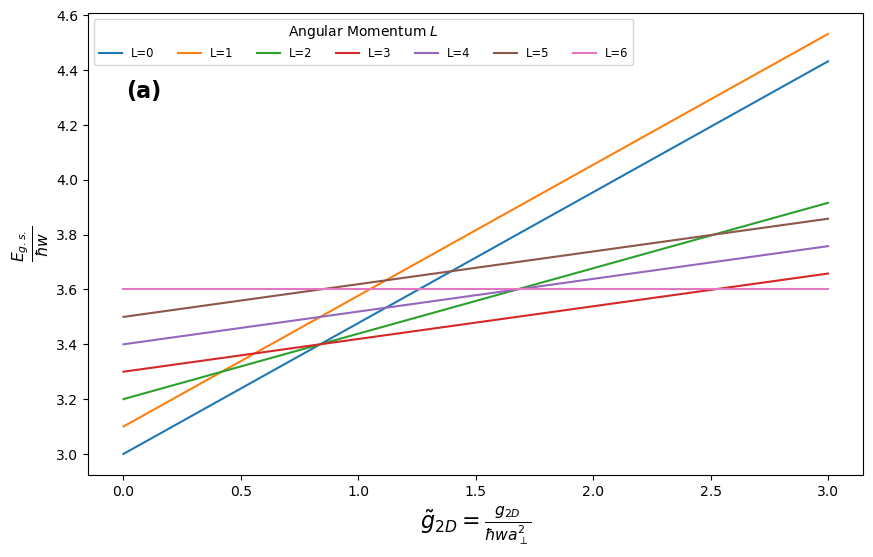

In [127]:
## Plots of the ground state energy for different g (adimensional)
N = 3
L_max = 6
adim_freq = 0.9 
g_2D_values = np.linspace(0, 3, 100) 

# Initilize list to store the g.s. energy for every L and g_2D 
ground_state_energies = {L: [] for L in range(L_max + 1)}

#Eigenvalues calculation
for L in range(0, L_max + 1):
    for g_2D in g_2D_values:
        H = Hamiltonian(N, L, g_2D)  
        eigenvalues, _ = np.linalg.eigh(H)
        ground_state_energies[L].append(np.min(eigenvalues))  

# Plot
plt.figure(figsize=(10, 6))

for L, ground_state in ground_state_energies.items():
    plt.plot(g_2D_values, ground_state, label=f"L={L}")

plt.xlabel(r'$\tilde{g}_{2D} = \frac{g_{2D}}{\hbar w a_{\perp}^2}$', fontsize = "16")
plt.ylabel(r'$\frac{E_{g.s.}}{\hbar w}$', fontsize = 16)
plt.text(0.01, 4.3, '(a)', fontsize=16, fontweight='bold')
plt.legend(
    title="Angular Momentum $L$",
    loc='upper left',
    ncol=L_max + 1,  
    fontsize='small')
plt.show()


<>:20: SyntaxWarning: invalid escape sequence '\O'
<>:28: SyntaxWarning: invalid escape sequence '\O'
<>:20: SyntaxWarning: invalid escape sequence '\O'
<>:28: SyntaxWarning: invalid escape sequence '\O'
C:\Users\glanc\AppData\Local\Temp\ipykernel_21012\3723926686.py:20: SyntaxWarning: invalid escape sequence '\O'
  plt.plot(L_values, energies, linestyle='None', marker='_', markersize=10, label=f'$\Omega/\omega$ = {adim_freq:.2f}')
C:\Users\glanc\AppData\Local\Temp\ipykernel_21012\3723926686.py:28: SyntaxWarning: invalid escape sequence '\O'
  plt.legend(title='$\Omega/\omega$')


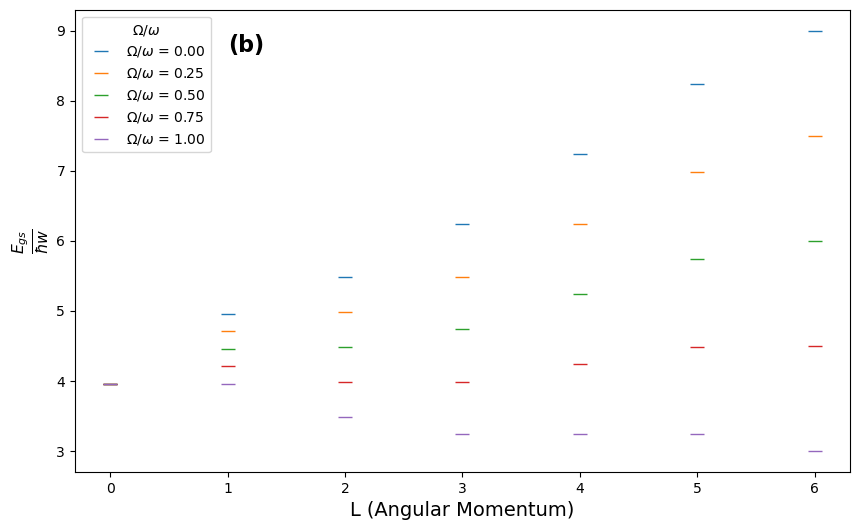

In [126]:
# Plot of the ground state energy in every L sector changing the ratio Ω/w
N = 3
L_max = 6
g_2D = 2
adim_freq_values = np.linspace(0, 1, 5)  # 5 values of adim_freq from 0 to 1
L_values = range(L_max + 1)

# Calculate ground state energy for each L and adim_freq
ground_state_energies = {adim_freq: [] for adim_freq in adim_freq_values}

for adim_freq in adim_freq_values:
    for L in L_values:
        H = Hamiltonian(N, L, g_2D)
        eigenvalues, _ = np.linalg.eigh(H)
        ground_state_energies[adim_freq].append(np.min(eigenvalues.real))  # Ground state energy

# Plotting
plt.figure(figsize=(10, 6))
for adim_freq, energies in ground_state_energies.items():
    plt.plot(L_values, energies, linestyle='None', marker='_', markersize=10, label=f'$\Omega/\omega$ = {adim_freq:.2f}')  
    


plt.xlabel('L (Angular Momentum)', fontsize = 14)
plt.ylabel(r'$\frac{E_{gs}}{\hbar w}$', fontsize = 16)
plt.text(1, 8.7, '(b)', fontsize=16, fontweight='bold')
plt.xticks(L_values)  # Ensure discrete ticks for L
plt.legend(title='$\Omega/\omega$')
plt.show()



In [11]:
#%% Eigenvalues and eigenvectors of the Hamiltonian for L = 0 to L = 6 for some parameters conditions to calculate the densities
N = 3
L = 6
adim_freq = 0.5
g_2D = 0.5
eigenvalues = np.empty((L+1,7))
eigenvectors = np.empty((L+1,7,7))
eigenvalues[:,:] = 0
eigenvectors[:,:,:] = 0
eigenvalues[0,:1], eigenvectors[0,:1,:1] = np.linalg.eigh(Hamiltonian(N,0,g_2D))

for l in range(1, L):
    H = Hamiltonian (N, l, g_2D)
    eigenvalues[l,:l], eigenvectors[l,:l,:l] = np.linalg.eigh(H)
    #print(l)
    #print('Eigenvalues for L = ', l,':' , eigenvalues)
    #print('Eigenvectors for L =', l, ':', eigenvectors)
    
eigenvalues[L,:L+1], eigenvectors[L,:L+1,:L+1] = np.linalg.eigh(Hamiltonian(N,L,g_2D))

C:\Users\glanc\AppData\Local\Temp\ipykernel_21012\4167861173.py:10: ComplexWarning: Casting complex values to real discards the imaginary part
  eigenvalues[0,:1], eigenvectors[0,:1,:1] = np.linalg.eigh(Hamiltonian(N,0,g_2D))
C:\Users\glanc\AppData\Local\Temp\ipykernel_21012\4167861173.py:14: ComplexWarning: Casting complex values to real discards the imaginary part
  eigenvalues[l,:l], eigenvectors[l,:l,:l] = np.linalg.eigh(H)
C:\Users\glanc\AppData\Local\Temp\ipykernel_21012\4167861173.py:19: ComplexWarning: Casting complex values to real discards the imaginary part
  eigenvalues[L,:L+1], eigenvectors[L,:L+1,:L+1] = np.linalg.eigh(Hamiltonian(N,L,g_2D))


In [12]:
#Function to calculate the density operator in 2nd quantization
def density(eigenvector: np.ndarray, N: int, L: int,z: float) -> float:
    '''Function that calculates the density in 2n quantization

    Args:
        eigenvector : array containing the g.s. vector
        N: number of atoms
        L : total angular momentum
        z: position 

    Return:
        float containing the value of the density
    '''
    rho = 0
    basis = fock_basis(N, L)
    for i in range(L+1):
        for j in range(L+1):
            for k in range(len(eigenvector)):
                new_state1 = basis[k].copy()
                new_state1[j] -= 1
                for l in range(len(eigenvector)):
                    new_state2 = basis[l].copy()
                    new_state2[i] -= 1
                    if np.multiply((new_state2 - new_state1),(new_state2 - new_state1)).sum() != 0 or np.any(new_state1 == -1):
                        continue
                    else:
                        rho +=np.sqrt(basis[l,i]*basis[k,j])*eigenvector[k]*np.conjugate(eigenvector[l])*z**j*np.exp(-np.abs(z)**2/2)/np.sqrt(np.pi*sp.special.factorial(j))*np.conjugate(z**i*np.exp(-np.abs(z)**2/2)/np.sqrt(np.pi*sp.special.factorial(i))) 
    return rho         

In [128]:
#Calculatin the density for all distances and eigenvectors for different L
z = np.arange(-4,4,0.01)
rho = np.empty((L+1,len(z)))
N = 3
for l in range(0,L+1):
    for i in range(len(z)):
        k = len(fock_basis(N, l))
        rho[l,i] = density(eigenvectors[l,:k,0],N,l,z[i])

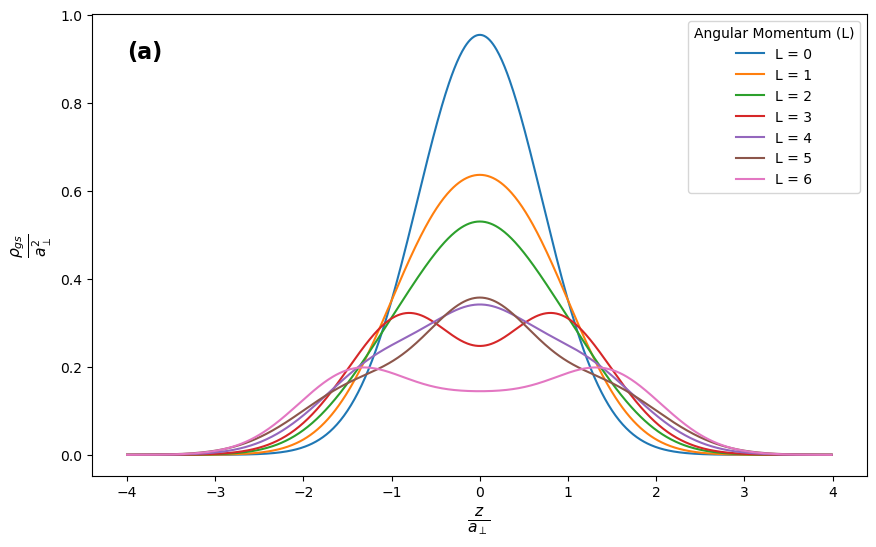

In [149]:
#1D plots of the density
plt.figure(figsize=(10, 6))
plt.xlabel(r'$\frac{z}{a_{\perp}}$', fontsize = "16")
plt.ylabel(r'$\frac{\rho_{gs}}{a_{\perp}^2}$', fontsize = "16")

for L in range(7):
    plt.plot(z, rho[L, :], label=f'L = {L}')

# Mostrar la leyenda
plt.legend(title='Angular Momentum (L)', loc='upper right')
plt.text(-4, 0.9, '(a)', fontsize=16, fontweight='bold')
plt.show()

In [21]:
#Calculating the density to make 2D plots
x = np.linspace(-4, 4, 400)
y = np.linspace(-4, 4, 400)
X, Y = np.meshgrid(x, y)
RHO = np.empty((L+1,len(x),len(y)))
for l in tqdm(range(0,L+1)):
    for re in range(len(x)):
        for im in range(len(y)):
            k = len(fock_basis(N, l))
            RHO[l,im,re] = density(eigenvectors[l,:k,0],N,l,x[re]+1j*y[im])

  0%|          | 0/7 [00:00<?, ?it/s]C:\Users\glanc\AppData\Local\Temp\ipykernel_21012\4140096284.py:10: ComplexWarning: Casting complex values to real discards the imaginary part
  RHO[l,im,re] = density(eigenvectors[l,:k,0],N,l,x[re]+1j*y[im])
100%|██████████| 7/7 [42:21<00:00, 363.06s/it]


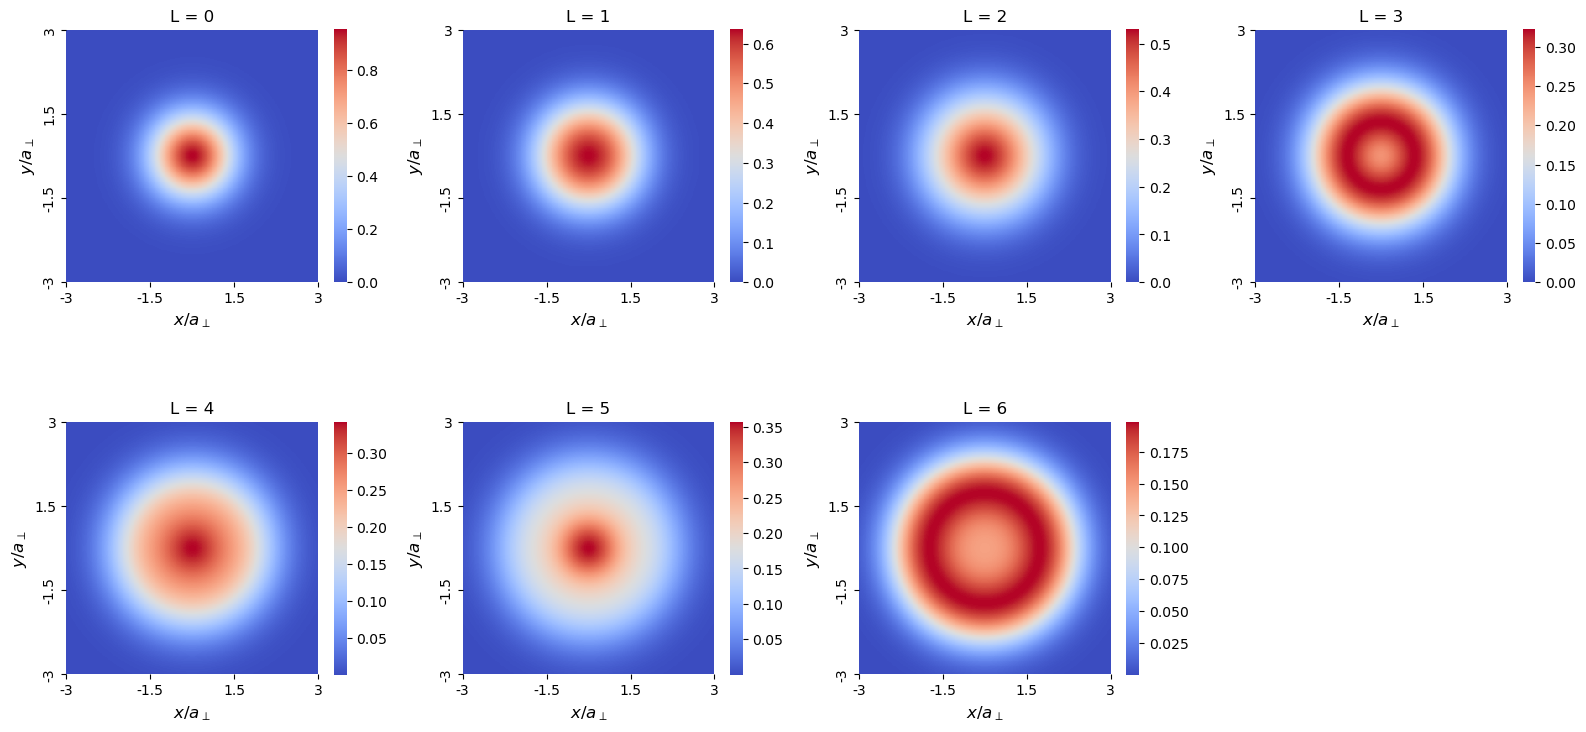

In [108]:
#2D plots for the densities
fig, axes = plt.subplots(2, 4, figsize=(16, 8))

titles = ["L = 0", "L = 1", "L = 2", "L = 3", "L = 4", "L = 5", "L = 6"]

# Flatten the axes and disable the last empty plot (position [1,3])
axes = axes.flatten()

for i in range(7):
    ax = axes[i]
    sns.heatmap(RHO[i, :, :], cmap="coolwarm", cbar=True, cbar_kws={'label': '', 'shrink': 0.7}, square=True,
                xticklabels=200, yticklabels=200, center=(np.min(RHO[i,:,:])+np.max(RHO[i,:,:]))/2, ax=ax)
    
    ax.set_xlabel(r"$x/a_{\perp}$", fontsize = "12")
    ax.set_ylabel(r"$y/a_{\perp}$", fontsize = "12")
    ax.set_xlim(50, 350)  # Aproximadamente corresponde a -3 a 3 (ajústalo si es necesario)
    ax.set_ylim(50, 350)
    
    # Ajustar los ticks y etiquetas para reflejar el rango de -3 a 3
    ax.set_xticks([50, 150, 250, 350])
    ax.set_xticklabels(["-3", "-1.5", "1.5", "3"])
    
    ax.set_yticks([50, 150, 250, 350])
    ax.set_yticklabels(["-3", "-1.5", "1.5", "3"])

    ax.set_title(titles[i])

# Ocultamos el último subplot vacío
fig.delaxes(axes[7])

plt.tight_layout()
plt.show()


In [38]:
#Maximum of the density
z_max = np.empty(L+1)

for i in range(L+1):
    idx = np.argmax(rho[i,:])
    z_max[i] = z[idx]

In [39]:
#%% Pair correlation operator 2nd quantization
def pair_corr(eigenvector: np.ndarray, N: int, L: int,z1: float,z2: float) -> float:
    '''Function to calculate the pair correlation for 2 particles in given positions z1 and z2 in 2nd quantization

    Args:
        eigenvector : array containing the g.s. vector
        N: number of atoms
        L : total angular momentum
        z1: position of the first particle
        z2: position of the second particle
    Return:
        float containing the value of the pair correlations
    
    '''
    pair = 0
    basis = fock_basis(N, L)
    for m in range(len(eigenvector)):
        for n in range(len(eigenvector)):
            for i in range(L+1):
                bra1 = basis[m].copy()
                bra1[i] -= 1
                if bra1[i] < 0 :
                    continue 
                else:
                    for j in range(L+1):
                        bra2 = bra1.copy()
                        bra2[j] -= 1
                        if bra2[j] <0 :
                            continue
                        else:
                            for k in range(L+1):
                                ket1 = basis[n].copy()
                                ket1[k] -= 1
                                if ket1[k] <0:
                                    continue 
                                else:
                                    for l in range(L+1):
                                        ket2 = ket1.copy()
                                        ket2[l] -= 1
                                        if ket2[l] < 0:
                                            continue 
                                        else:
                                            if np.multiply((ket2 - bra2),(ket2 - bra2)).sum() == 0:
                                                pair +=np.sqrt((bra1[i]+1)*(bra2[j]+1)*(ket1[k]+1)*(ket2[l]+1))*eigenvector[n]*np.conjugate(eigenvector[m])*np.conjugate(z1**i*np.exp(-np.abs(z1)**2/2)/np.sqrt(np.pi*math.factorial(i))*z2**j*np.exp(-np.abs(z2)**2/2)/np.sqrt(np.pi*math.factorial(j)))*z1**k*np.exp(-np.abs(z1)**2/2)/np.sqrt(np.pi*math.factorial(k))*z2**l*np.exp(-np.abs(z2)**2/2)/np.sqrt(np.pi*math.factorial(l)) 
          
    return pair      

In [140]:
#Calculating the pair correlations for all distances and different L
z = np.arange(-4,4,0.01)
pair = np.empty((L+1,len(z)))
N = 3
for l in tqdm(range(0,L+1)):
    for i in range(len(z)):
        k = len(fock_basis(N, l))
        pair[l,i] = pair_corr(eigenvectors[l,:k,0],N,l,z[i],z_max[l])

100%|██████████| 7/7 [00:21<00:00,  3.02s/it]


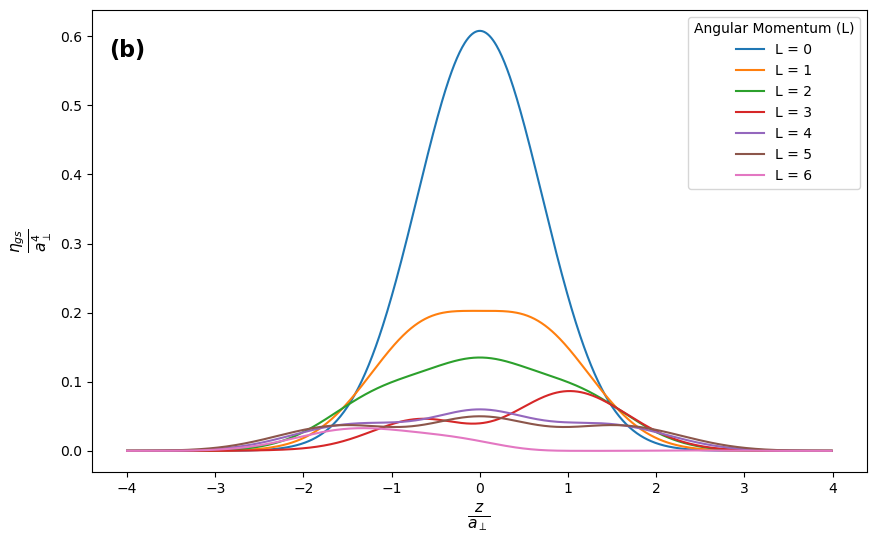

In [158]:
#1D plots of pair correlations
plt.figure(figsize=(10, 6))
plt.xlabel(r'$\frac{z}{a_{\perp}}$', fontsize = "16")
plt.ylabel(r'$\frac{\eta_{gs}}{a_{\perp}^4}$', fontsize = "16")

for L in range(7):
    plt.plot(z, pair[L, :], label=f'L = {L}')

# Mostrar la leyenda
plt.legend(title='Angular Momentum (L)', loc='upper right')
plt.text(-4.2, 0.57, '(b)', fontsize=16, fontweight='bold')
plt.show()

In [42]:
#2D plot for the pair correlation for any distance and all values of L
x = np.linspace(-4, 4, 400)
y = np.linspace(-4, 4, 400)
X, Y = np.meshgrid(x, y)
PAIR1 = np.empty((L+1,len(x),len(y)))
for l in range(0,L+1):
    for re in tqdm(range(len(x))):
        for im in range(len(y)):
            k = len(fock_basis(N, l))
            PAIR1[l,im,re] = pair_corr(eigenvectors[l,:k,0],N,l,x[re]+1j*y[im],z_max[l])

  0%|          | 0/400 [00:00<?, ?it/s]C:\Users\glanc\AppData\Local\Temp\ipykernel_21012\2807880564.py:10: ComplexWarning: Casting complex values to real discards the imaginary part
  PAIR1[l,im,re] = pair_corr(eigenvectors[l,:k,0],N,l,x[re]+1j*y[im],z_max[l])
100%|██████████| 400/400 [25:11<00:00,  3.78s/it]


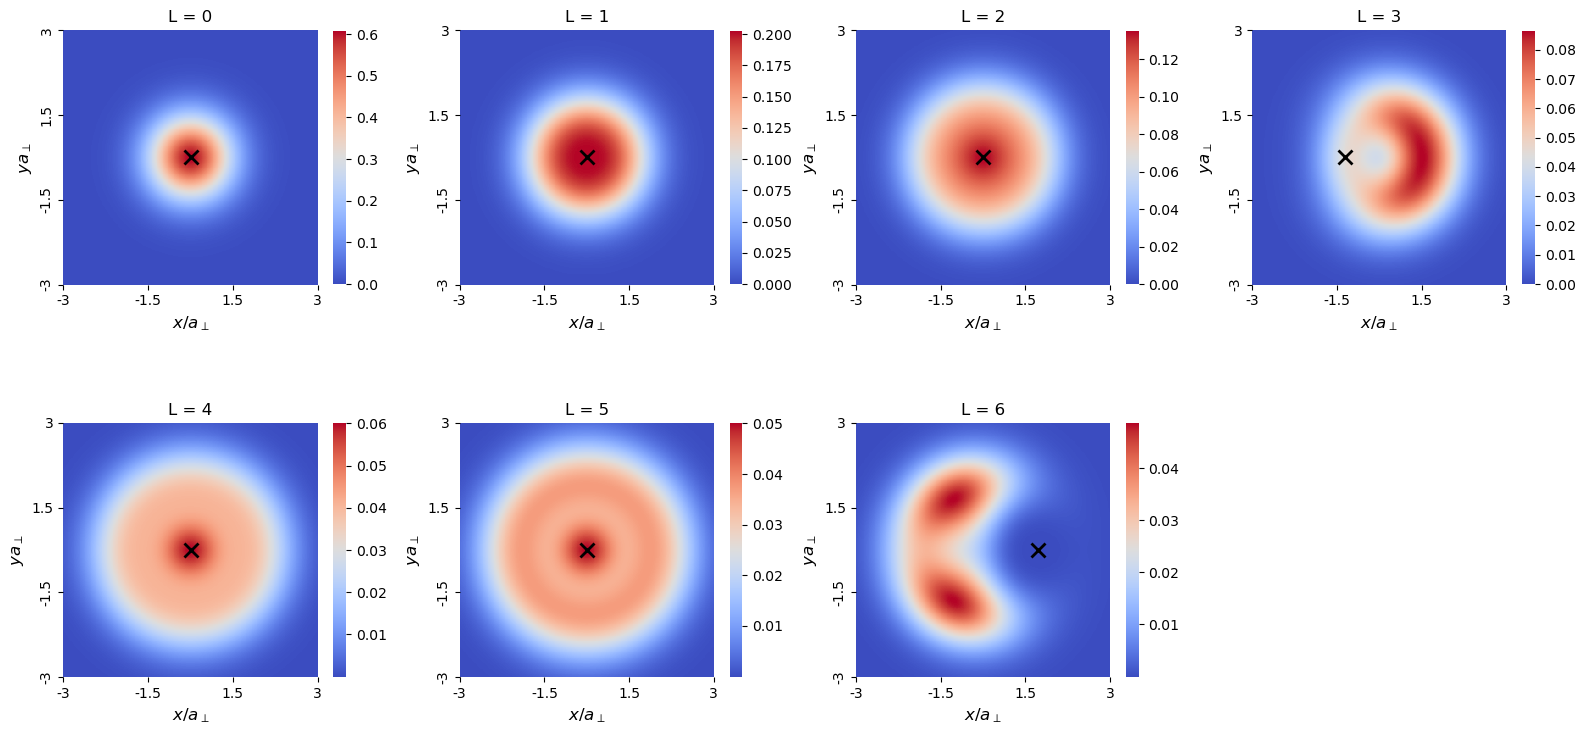

In [110]:
#Making the 2D plots for the pair correlations for every L
fig, axes = plt.subplots(2, 4, figsize=(16, 8))

titles = ["L = 0", "L = 1", "L = 2", "L = 3", "L = 4", "L = 5", "L = 6"]

# Flatten the axes and disable the last empty plot (position [1,3])
axes = axes.flatten()

for i in range(7):
    ax = axes[i]
    sns.heatmap(PAIR1[i, :, :], cmap="coolwarm", cbar=True, cbar_kws={'label': '', 'shrink': 0.7}, square=True,
                xticklabels=200, yticklabels=200, center=(np.min(PAIR1[i,:,:])+np.max(PAIR1[i,:,:]))/2, ax=ax)
    
    ax.set_xlabel(r"$x/a_{\perp}$", fontsize = "12")
    ax.set_ylabel(r"$ya_{\perp}$", fontsize = "12")
    ax.set_xlim(50, 350) 
    ax.set_ylim(50, 350)
    ax.set_xticks([50, 150, 250, 350,])
    ax.set_xticklabels(["-3", "-1.5", "1.5", "3"])
    ax.set_yticks([50, 150, 250, 350])
    ax.set_yticklabels(["-3", "-1.5", "1.5", "3"])
    ax.set_title(titles[i])
    ax.plot(int((z_max[i]+4)*400/8), 200, marker='x', markersize=10, color='black', mew=2)

# Ocultamos el último subplot vacío
fig.delaxes(axes[7])

plt.tight_layout()
plt.show()

In [ ]:
#2D plot of the pair correlation density varying both positions in real space
z1 = np.linspace(-4, 4, 400)
z2 = np.linspace(-4, 4, 400)
Z1, Z2 = np.meshgrid(z1, z2)
PAIR2 = np.empty((L+1,len(z1),len(z2)))
for l in tqdm(range(0,3)):
    for re in range(len(z1)):
        for im in range(len(z2)):
            k = len(fock_basis(N, l))
            PAIR2[l,im,re] = pair_corr(eigenvectors[l,:k,0],N,l,z1[re],z2[im])

#This part of the code lasts long.For this reason it was run on Marc's computer and I collect the data

In [137]:
#Read the data from the results obtained in Marc's computer
folder_path = '/Users/glanc/OneDrive/Escritorio/QSimulators'
file_name = 'g=0.5_omega=0.5.json'
file_path = os.path.join(folder_path, file_name)
with open(file_path, 'r') as inputFile:
    data = json.load(inputFile)
    RHO = np.array(data['rho'])
    PAIR1 = np.array(data['pair1'])
    PAIR2 = np.array(data['pair2'])


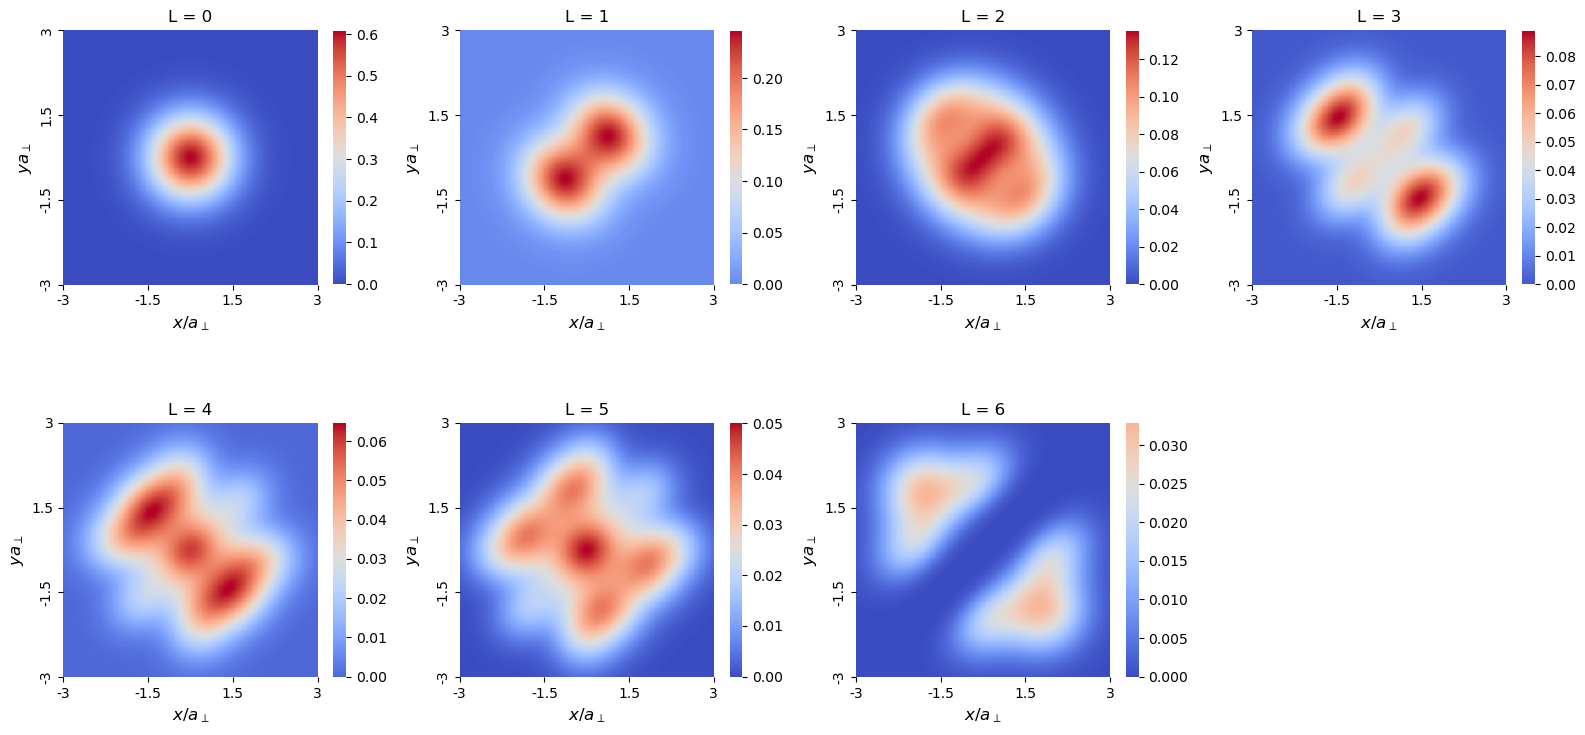

In [139]:
#Making the 2D plots for the pair correlations for every L
fig, axes = plt.subplots(2, 4, figsize=(16, 8))

titles = ["L = 0", "L = 1", "L = 2", "L = 3", "L = 4", "L = 5", "L = 6"]

# Flatten the axes and disable the last empty plot (position [1,3])
axes = axes.flatten()

for i in range(7):
    ax = axes[i]
    sns.heatmap(PAIR2[i, :, :], cmap="coolwarm", cbar=True, cbar_kws={'label': '', 'shrink': 0.7}, square=True,
                xticklabels=200, yticklabels=200, center=(np.min(PAIR2[i,:,:])+np.max(PAIR2[i,:,:]))/2, ax=ax)
    
    ax.set_xlabel(r"$x/a_{\perp}$", fontsize = "12")
    ax.set_ylabel(r"$ya_{\perp}$", fontsize = "12")
    ax.set_xlim(50, 350) 
    ax.set_ylim(50, 350)
    ax.set_xticks([50, 150, 250, 350,])
    ax.set_xticklabels(["-3", "-1.5", "1.5", "3"])
    ax.set_yticks([50, 150, 250, 350])
    ax.set_yticklabels(["-3", "-1.5", "1.5", "3"])
    ax.set_title(titles[i])
    #ax.plot(int((z_max[i]+4)*400/8), 200, marker='x', markersize=10, color='black', mew=2)

# Ocultamos el último subplot vacío
fig.delaxes(axes[7])

plt.tight_layout()
plt.show()

In [160]:
def laughlin_wavefunction(z, Z, m=2) :
    """
    For a single particle coordinate z and an array Z of the other particle coordinates,
    returns the factor of the Laughlin wavefunction that depends on z:
    
    For the full N-particle Laughlin state (with N-1 other coordinates), one would have:
    
        Psi(z, z2,..., z_N) = \prod_{j=2}^N (z - z_j)^m \prod_{2\le i<j\le N}(z_i-z_j)^m exp(-(|z|^2+...+|z_N|^2)/2).
    
    Here we return only the z-dependent factor:
    
        \prod_{j=2}^N (z - z_j)^m * exp(-|z|^2/2).
    
    (The remaining factors that depend only on the other coordinates will cancel in a proper MC estimation.)
    """
    psi = 1.0
    for zi in Z:
        psi *= (z - zi)**m 
    return psi * np.exp(-np.abs(z)**2/2)

<>:2: SyntaxWarning: invalid escape sequence '\p'
<>:2: SyntaxWarning: invalid escape sequence '\p'
C:\Users\glanc\AppData\Local\Temp\ipykernel_21012\3720970235.py:2: SyntaxWarning: invalid escape sequence '\p'
  """


In [161]:
def monte_carlo_laughlin_density(N, grid, num_samples=1000000, m=2):
    """
    Compute the single-particle density of the N-particle Laughlin state using Monte Carlo integration.
    We want to compute:
    
        ρ(z) ∝ ∫ d^2z_2 ... d^2z_N |Ψ(z, z_2, ..., z_N)|^2,
        
    with
        
        |Ψ(z,z_2,...,z_N)|^2 = |z-z_2|^{2m} |z-z_3|^{2m} ... |z_2-z_3|^{2m} ... exp(-|z|^2 -∑_{j=2}^N|z_j|^2).
    
    We sample each z_j (for j=2,...,N) from the normalized distribution:
    
        p(z)=1/π exp(-|z|^2),
    
    which is achieved by taking
        z = (np.random.randn()+1j*np.random.randn())/√2.
    
    In importance sampling the weight for a given set {z_2,...,z_N} is:
    
        w(z, {z_j}) = π^(N-1) exp(-|z|^2) ∏_{j=2}^N |z-z_j|^{2m} ∏_{2≤i<j≤N} |z_i-z_j|^{2m}.
    
    Finally, the density is normalized on the grid.
    """
    density_vals = np.zeros_like(grid, dtype=float)
    # Set the seed for reproducibility
    np.random.seed(42)
    
    # Precompute the constant factor from importance sampling:
    weight_prefactor = np.pi**(N-1)
    
    # For each grid point (each complex number z) we will average over samples of the remaining N-1 particles.
    # We sample the other coordinates from p(z)=1/π exp(-|z|^2).
    # To do this, we generate samples with standard deviation 1/√2.
    Z_samples = (np.random.randn(num_samples, N-1) + 1j * np.random.randn(num_samples, N-1)) / np.sqrt(2)
    
    # Loop over grid points
    it = np.nditer(grid, flags=['multi_index'])
    while not it.finished:
        z = it[0]
        # For each sample, compute the product over j: |z - z_j|^(2m)
        # and also the pairwise factors among the sampled coordinates.
        prod_single = np.prod(np.abs(z - Z_samples)**(2*m), axis=1)
        
        # Now compute the product over pairs among the sampled other particles.
        prod_pairs = np.ones(num_samples)
        # There are N-1 particles; loop over all pairs i<j.
        for i in range(N-1):
            for j in range(i+1, N-1):
                prod_pairs *= np.abs(Z_samples[:, i] - Z_samples[:, j])**(2*m)
                
        # The weight for each sample is then:
        #   w = weight_prefactor * exp(-|z|^2) * prod_single * prod_pairs.
        weights = weight_prefactor * np.exp(-np.abs(z)**2) * prod_single * prod_pairs
        
        # The Monte Carlo estimator for ρ(z) is the average of these weights.
        density_vals[it.multi_index] = np.mean(weights)
        
        it.iternext()
    
    # Normalize the density on the grid.
    dx = np.abs(grid[1, 0] - grid[0, 0])
    total = np.sum(density_vals) * dx**2
    density_normalized = density_vals / total
    return density_normalized

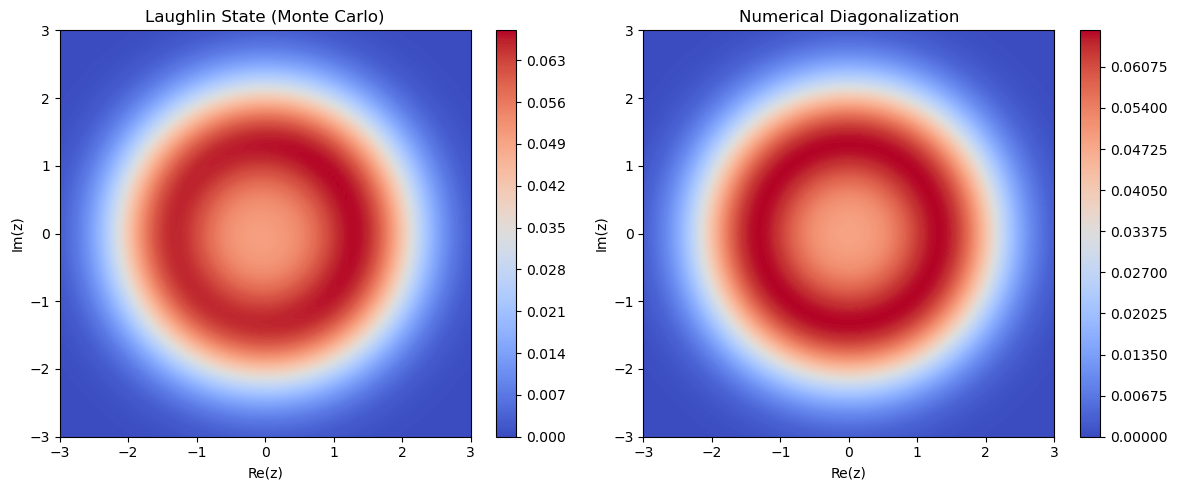

In [167]:
N = 3
L = 6  # For the Laughlin state with m=2, total L = m*N*(N-1)/2 = 6.
adim_freq = 0.5
g_2D = 0.5

# Compute eigenvalues and eigenvectors by diagonalizing the Hamiltonian for L = 6.
# (Here we assume that the L=6 sector contains the Laughlin state.)
H = Hamiltonian(N, L, g_2D, adim_freq)
eigvals, eigvecs = eigh(H)
# We take the lowest eigenstate.
psi_numerical = eigvecs[:, 0]

# Define the grid in the complex plane for plotting.
x = np.linspace(-3, 3, 100)
y = np.linspace(-3, 3, 100)
X, Y = np.meshgrid(x, y)
Z = X + 1j * Y
dx = (x[1]-x[0])

# Compute the density from diagonalization.
rho_numerical = density(psi_numerical, N, L, Z)
total_num = np.sum(np.abs(rho_numerical)) * dx**2
rho_numerical_normalized = np.real(rho_numerical) / total_num  # take real part

# Compute the analytical (Laughlin) density using Monte Carlo integration.
rho_analytical = monte_carlo_laughlin_density(N, Z)

# Compute the overlap (discrete integration) between the two densities.
overlap = np.sum(rho_analytical * rho_numerical_normalized) * dx**2

# Plot the two densities side-by-side.
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

c1 = axes[0].contourf(X, Y, rho_analytical, levels=300, cmap="coolwarm")
plt.colorbar(c1, ax=axes[0])
axes[0].set_title("Laughlin State (Monte Carlo)")
axes[0].set_xlabel("Re(z)")
axes[0].set_ylabel("Im(z)")

c2 = axes[1].contourf(X, Y, rho_numerical_normalized, levels = 300, cmap="coolwarm")
plt.colorbar(c2, ax=axes[1])
axes[1].set_title("Numerical Diagonalization")
axes[1].set_xlabel("Re(z)")
axes[1].set_ylabel("Im(z)")

plt.tight_layout()
plt.show()


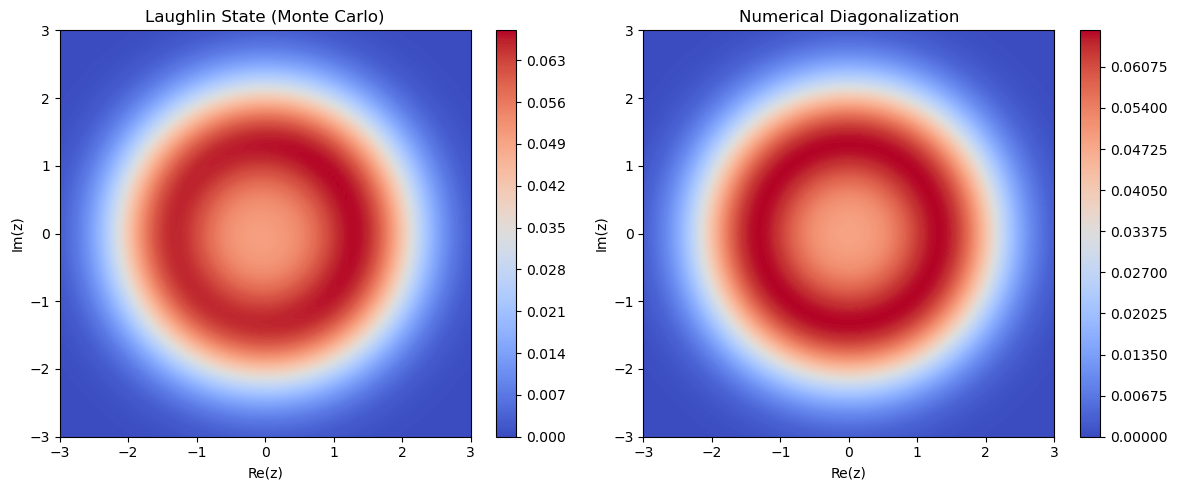

In [166]:
# Plot the two densities side-by-side.
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

c1 = axes[0].contourf(X, Y, rho_analytical, levels=300, cmap="coolwarm")
plt.colorbar(c1, ax=axes[0])
axes[0].set_title("Laughlin State (Monte Carlo)")
axes[0].set_xlabel("Re(z)")
axes[0].set_ylabel("Im(z)")

c2 = axes[1].contourf(X, Y, rho_numerical_normalized, levels=300, cmap="coolwarm")
plt.colorbar(c2, ax=axes[1])
axes[1].set_title("Numerical Diagonalization")
axes[1].set_xlabel("Re(z)")
axes[1].set_ylabel("Im(z)")

plt.tight_layout()
plt.show()